As always we start by installing the dependencies we need

In [ ]:
!pip install alibi shap xgboost lime eli5 interpret

Next we load a few libraries, nothing fancy here so far.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now we can read in the toy dataset

In [ ]:
csv = pd.read_csv("/content/drive/MyDrive/MQL5 Articles/The Dissagrement Problem/Madden 23 Player Ratings.csv")

Let's look at the dataset

In [ ]:
csv.head()

Full Name     Team Position        college  awareness_rating  \
0    Aaron Donald     Rams       RE     Pittsburgh                99   
1   Davante Adams  Raiders       WR   Fresno State                99   
2   Myles Garrett   Browns       RE       Texas AM                98   
3  Trent Williams    49ers       LT       Oklahoma                99   
4     Cooper Kupp     Rams       WR  Eastern Wash.                99   

   throwPower_rating  kickReturn_rating  leadBlock_rating  strength_rating  \
0                 20                 10                23               99   
1                 45                 45                25               63   
2                 55                 10                17               96   
3                 12                 10                98               98   
4                 59                 84                34               66   

   bCVision_rating  ...       archetype  blockShedding_rating  \
0               49  ...  DE_PowerRusher                    97   
1               94  ...   WR_DeepThreat                    52   
2               39  ...  DE_PowerRusher                    90   
3               10  ...        OT_Power                    32   
4               96  ...         WR_Slot                    28   

   runBlockFinesse_rating teamId  agility_rating  fullNameForSearch  \
0                      45     24              86       Aaron Donald   
1                      12     23              95      Davante Adams   
2                      45      5              85      Myles Garrett   
3                      99     15              73     Trent Williams   
4                      28     24              95        Cooper Kupp   

   overall_rating  passBlockFinesse_rating  age  primaryKey  
0              99                       45   31       10852  
1              99                       17   29       10823  
2              99                       45   26       12520  
3              99                       92   34        9800  
4              98                       34   29       12558  

[5 rows x 80 columns]

To keep things simple we will only keep a few of the numerical features.

The categorical features require encoding techniques and details that are not aligned with the scope of our discussion.

In [ ]:
predictors = ["awareness_rating","throwPower_rating","kickReturn_rating",
              "leadBlock_rating","strength_rating","catchInTraffic_rating",
              "pursuit_rating", "catching_rating","acceleration_rating",
              "height","tackle_rating","yearsPro","throwUnderPressure_rating",
              "throwAccuracyDeep_rating","throwAccuracyShort_rating","speed_rating",
              "jumping_rating","toughness_rating","kickPower_rating",
              "kickAccuracy_rating","agility_rating","passBlock_rating","age"
             ]

csv[predictors].dtypes

awareness_rating             int64
throwPower_rating            int64
kickReturn_rating            int64
leadBlock_rating             int64
strength_rating              int64
catchInTraffic_rating        int64
pursuit_rating               int64
catching_rating              int64
acceleration_rating          int64
height                       int64
tackle_rating                int64
yearsPro                     int64
throwUnderPressure_rating    int64
throwAccuracyDeep_rating     int64
throwAccuracyShort_rating    int64
speed_rating                 int64
jumping_rating               int64
toughness_rating             int64
kickPower_rating             int64
kickAccuracy_rating          int64
agility_rating               int64
passBlock_rating             int64
age                          int64
dtype: object

Define the target

In [ ]:
target = "totalSalary"

Import the models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from xgboost import plot_importance

We will use an explainable modle in order to assess which explainer was providing faithful intepretations

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

Scale the data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(csv.loc[:,predictors])

StandardScaler()

In [ ]:
scaled_data = pd.DataFrame(scaler.transform(csv.loc[:,predictors]),index=csv.index,columns = predictors)

Train/Test Split

In [ ]:
train_size = int(csv.shape[0] * 0.6)
validation_size = int(csv.shape[0] * 0.1)
test_size = int(csv.shape[0] * 0.3)

train = 0
train_end = train + train_size
validation = train_end + 1
validation_end = validation +  validation_size
test = validation_end + 1
test_end = test + test_size

x_train = scaled_data.loc[train:train_end]
y_train = csv.loc[train:train_end,target]

x_validation = scaled_data.loc[validation:validation_end]
y_validation = csv.loc[validation:validation_end,target]

x_test = scaled_data.loc[test:test_end]
y_test = csv.loc[test:test_end,target]

Instatiating The Models

In [ ]:
lm = LinearRegression()
ebm = ExplainableBoostingRegressor()
xgb = XGBRegressor()
knn = KNeighborsRegressor(n_neighbors=10)
dnn = keras.Sequential([
    layers.Dense(units=30,activation="relu",input_shape=[scaled_data.shape[1]]),
    layers.Dense(units=20,activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(units=10,activation="relu"),
    layers.Dense(units=1)
])

Fitting The Linear Model

In [ ]:
lm.fit(x_train,y_train)

LinearRegression()

Fitting The Explainable Boosting Machine

In [ ]:
ebm.fit(x_train,y_train)

ExplainableBoostingRegressor()

Fitting The XGB Model

In [ ]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Fitting The KNN Model

In [ ]:
knn.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=10)

Fitting The Deep Neural Network

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
dnn.compile(optimizer="adam",loss="mae")

In [ ]:
dnn.fit(
    x_train,y_train,
    validation_data=(x_validation,y_validation),
    batch_size = 60,
    epochs=100,
    verbose=0,
    callbacks=[early_stopping]
)

Global Explanations

We will start with global explanations of each model. The technique we will use is permutation importance. It is a black-box global epxlanation technique.

In [ ]:
import eli5
from sklearn.metrics import mean_squared_error
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

Let's Get Global Explanations For Our Models

Linear Model Permutation Importance



In [ ]:
permutation = PermutationImportance(lm).fit(x_test,y_test)
eli5.show_weights(permutation,feature_names = predictors)

XGB Permutation Importance

In [ ]:
permutation = PermutationImportance(xgb).fit(x_test,y_test)
eli5.show_weights(permutation,feature_names = predictors)

Explainable Boosting Machine Permutation Importance

In [ ]:
permutation = PermutationImportance(ebm).fit(x_test,y_test)
eli5.show_weights(permutation,feature_names = predictors)

In [ ]:
permutation = PermutationImportance(knn).fit(x_test,y_test)
eli5.show_weights(permutation,feature_names = predictors)

**Local Explanations**


---




Local explanations help us understand how each individual prediction was made by the model and which factors contributed to that decision.

One example of an algorithm designed to give local explanations is Locally Intepretable Model-Agnostic Explanations or just LIME.

Linear Regression Model

Let's apply LIME Onto our Linear Regression And Get Local Explanations For Richard Rodgers

Applying LIME onto our models can help us better understand the predictions the model is making for each athlete in the test set.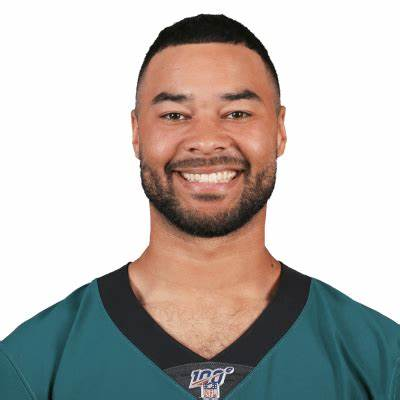

Local explanation of Richard Rodgers' salary expectations

In [ ]:
import lime
from lime import lime_tabular

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(training_data = np.array(x_train),mode='regression',feature_names=predictors)
exp = explainer.explain_instance(data_row=scaled_data.iloc[test],predict_fn=lm.predict)
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but LinearRegression was fitted with feature names


**Deep Neural Network Local Explanations**

Local Explanations For Richard LeCounte's Salary Expectations

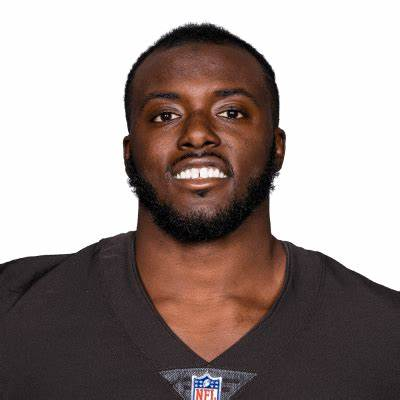

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(training_data = np.array(x_train),mode='regression',feature_names=predictors)
exp = explainer.explain_instance(data_row=scaled_data.iloc[test+1],predict_fn=dnn.predict)
exp.show_in_notebook(show_table=True)

157/157 [==============================] - 0s 2ms/step


**White-Box & Black-Box Explainers**

---

Black-Box Explainers

In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(xgb.predict,scaled_data.loc[test:test_end,predictors])
shap_values = explainer(scaled_data.loc[test:test_end,predictors])

PermutationExplainer explainer: 711it [02:24,  4.58it/s]


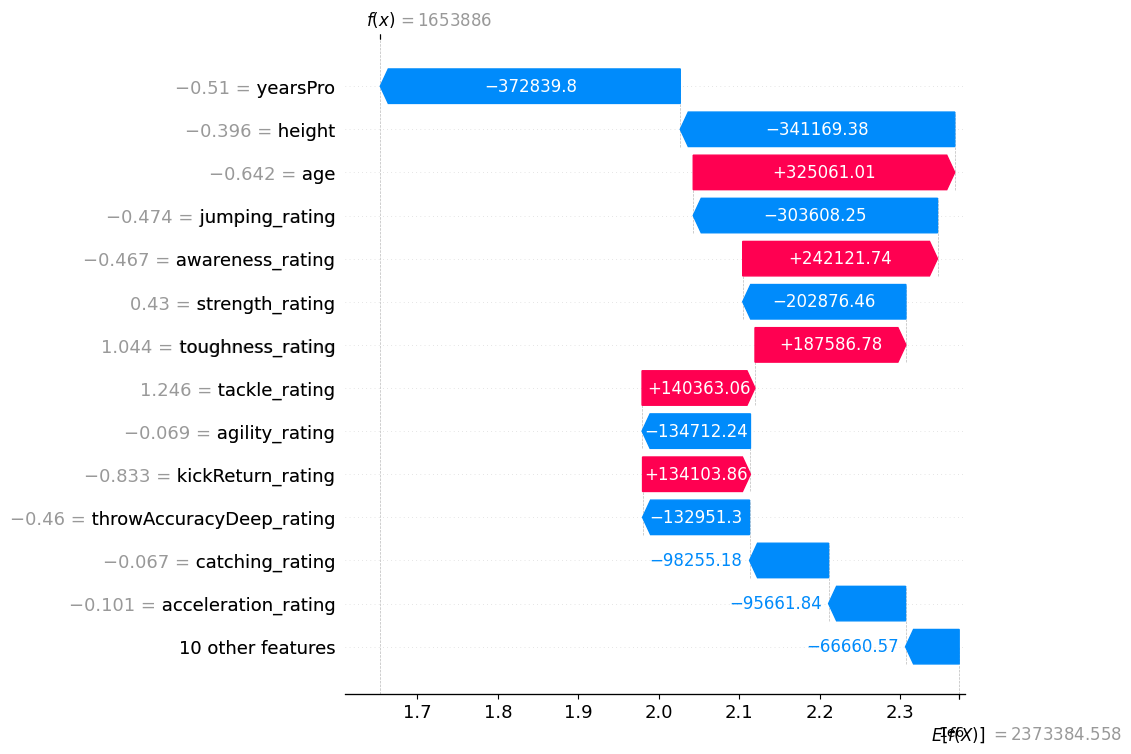

In [ ]:
shap.initjs()
shap.plots.waterfall(shap_values[10], max_display=14)

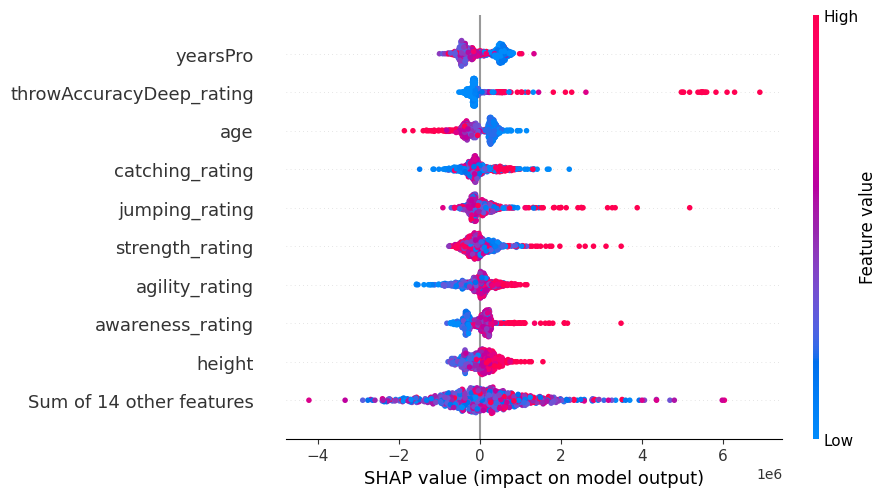

In [ ]:
shap.plots.beeswarm(shap_values)

White-Box Explainers

In [ ]:
tree_explainer = shap.TreeExplainer(xgb)
tree_shap_values = explainer(x_test)

PermutationExplainer explainer: 711it [01:25,  7.82it/s]                         


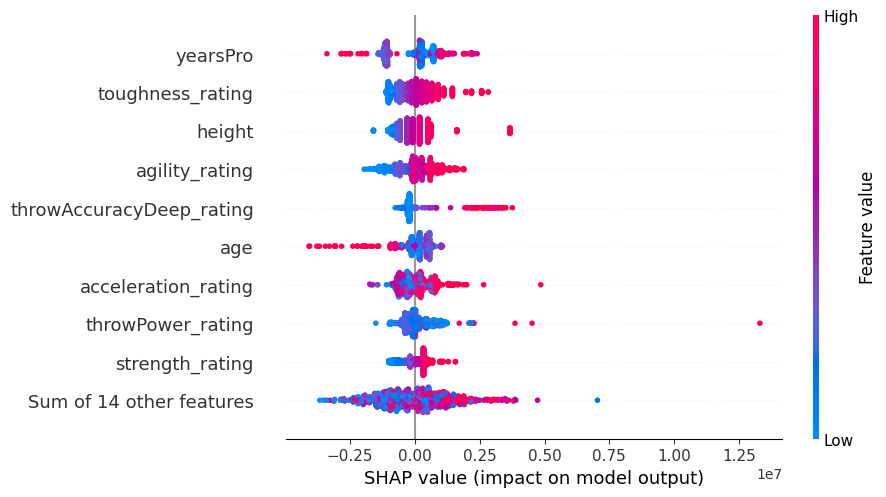

In [ ]:
shap.plots.beeswarm(tree_shap_values)

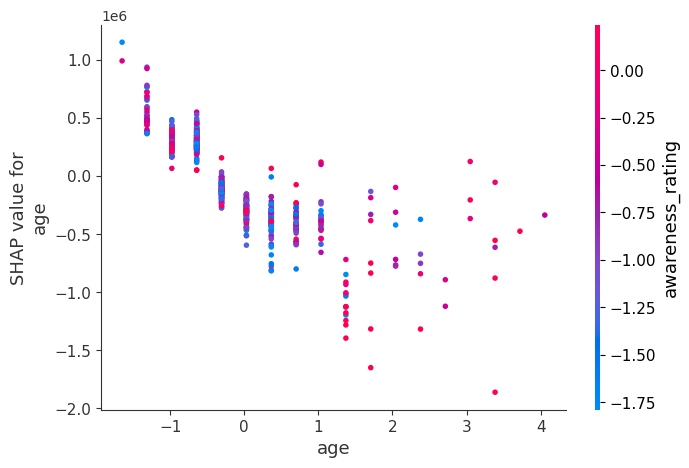

In [ ]:
shap.dependence_plot("age",shap_values.values,x_test,interaction_index="awareness_rating")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

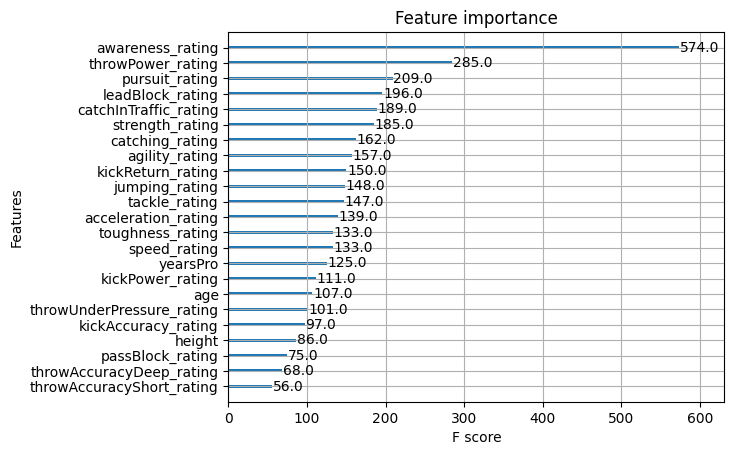

In [ ]:
plot_importance(xgb)

In [ ]:
show(ebm.explain_global())